In [1]:
import sys
import pyBigWig
import matplotlib
from datetime import datetime
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=8)

sys.path.append('/home/zhangjy/data/git/BIOLS')
from py3biotools import *
from py3biotools.bioinfo import Faidx, GTFParser
from py3biotools.pltools import Circos
matplotlib.use('Agg')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Imported modules for python bioinformatics analysis
Author: Jinyang Zhang
Email: zhangjinyang@biols.ac.cn
Version: 1.0
3.6.8 (default, Aug 18 2020, 08:33:21) 
[GCC 8.3.1 20191121 (Red Hat 8.3.1-5)]


In [2]:
gtf_file = '/home/zhangjy/public/database/GENCODE/Mouse_Release_M26/gencode.vM26.annotation.gtf'
genome_file = '/home/zhangjy/public/database/GENCODE/Mouse_Release_M26/GRCm39.genome.fa'
phastcon_file = "/home/zhangjy/storage/Lenovo_backup/zhangjy/03.CIRI-long/data/PhastCons/mm10.60way.phastCons.bw"
phyloP_file = "/home/zhangjy/storage/Lenovo_backup/zhangjy/03.CIRI-long/data/PhyloP/mm10.60way.phyloP60way.bw"
bed_file = '/home/zhangjy/storage/Lenovo_backup/zhangjy/03.CIRI-long/data/mecciRNAs/mm9_ShanGe.bed'

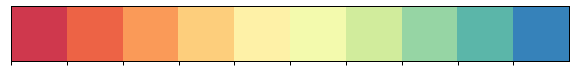

In [3]:
# Load color palette
mtcolors = sns.color_palette('Spectral', 10)
sns.palplot(mtcolors)

In [4]:
# Load reference genome
fasta = Faidx(genome_file)

# Load annotation gtf
gene_index = {}
with open(gtf_file, 'r') as gtf:
    for line in gtf:
        if line.startswith('#'):
            continue
        content = line.rstrip().split('\t')
        parser = GTFParser(content)
        if parser.type == 'gene':
            gene_index[parser.attr['gene_name']] = parser
            
mtgenes = [i for i in gene_index if gene_index[i].contig == 'chrM']
h_genes = []
l_genes = []
for i in mtgenes:
    if gene_index[i].attr['gene_type'] == 'Mt_tRNA':
        color = 'grey'
    elif gene_index[i].attr['gene_type'] == 'Mt_rRNA':
        color = mtcolors[7]
    elif gene_index[i].attr['gene_type'] == 'protein_coding':
        if 'mt-Nd' in gene_index[i].attr['gene_name']:
            color = mtcolors[0]
        elif 'mt-Co' in gene_index[i].attr['gene_name']:
            color = mtcolors[3]
        elif 'mt-Atp' in gene_index[i].attr['gene_name']:
            color = mtcolors[9]
        else:
            color = mtcolors[8]
    if gene_index[i].strand == '+':
        h_genes.append([gene_index[i].contig, gene_index[i].start, gene_index[i].end, gene_index[i].attr['gene_name'], color])
    else:
        l_genes.append([gene_index[i].contig, gene_index[i].start, gene_index[i].end, gene_index[i].attr['gene_name'], color])

h_genes = pd.DataFrame(h_genes, columns=['chrom', 'start', 'end', 'band', 'color'])
l_genes = pd.DataFrame(l_genes, columns=['chrom', 'start', 'end', 'band', 'color'])

In [5]:
# Load bigWig track
phyloP_bw = pyBigWig.open(phyloP_file)
mt_scores = pd.DataFrame(
    [['chrM', i, min(fasta.contig_len['chrM'], i+25), phyloP_bw.stats('chrM', i, min(fasta.contig_len['chrM'], i+25))[0]] for i in np.arange(0, fasta.contig_len['chrM'], 25)],
    columns=['chromosome', 'start', 'end', 'score']
)
phyloP_bw.close()
mt_scores.head()

,chromosome,start,end,score
0,chrM,0,25,3.56524
1,chrM,25,50,3.15056
2,chrM,50,75,0.37772
3,chrM,75,100,2.54940
4,chrM,100,125,2.75968


In [6]:
def convert_bed_to_track(df, gap=0):
    stack = [[], ]
    for _, row in df.iterrows():
        for idx, tmp_list in enumerate(stack):
            if len(tmp_list) == 0 or tmp_list[-1][2] < row['start'] - gap:
                stack[idx].append(row)
                break
        else:
            stack.append([row])
    return stack

# Load circRNA bed file
circ_df = pd.read_csv(bed_file, sep=" ", header=None)
circ_df.columns = ["contig", "start", "end", "strand", "name"]
circ_df = circ_df.sort_values(by=["start", "end"])

h_circs = convert_bed_to_track(circ_df.loc[circ_df['strand'] == "H"], 100)
l_circs = convert_bed_to_track(circ_df.loc[circ_df['strand'] == "L"], 100)
len(h_circs), len(l_circs)

(78, 34)

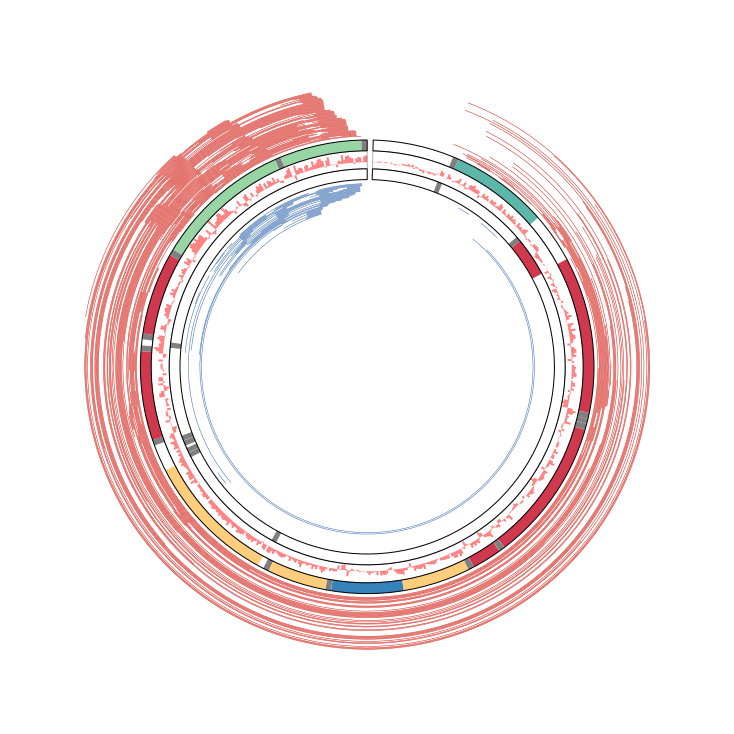

In [22]:
# Draw circos plot
contigs = pd.DataFrame({'length': [fasta.contig_len['chrM'], ]}, index=['chrM', ])
cg = Circos(contigs, gap=1.5)

# y, width
g_tracks = [[5.2, .3], [5.5, .5], [6, .3]]

# Light strand genes
cg.draw_cytobands(g_tracks[0][0], g_tracks[0][1], l_genes, edgecolor=None)
cg.draw_scaffold(g_tracks[0][0], g_tracks[0][1], alpha=1)

# PhastCons values
cg.draw_scaffold(g_tracks[1][0], g_tracks[1][1], alpha=.3)
cg.fill_between(g_tracks[1][0]+g_tracks[1][1]*np.abs(mt_scores['score'].min())/(mt_scores['score'].max()-mt_scores['score'].min()),
                mt_scores, gid='chromosome', start='start', end='end', score='score', scale=g_tracks[1][1]/(mt_scores['score'].max()-mt_scores['score'].min()), 
                facecolor='red', alpha=.5, edgecolor=None, linewidth=0)
# Heavy strand genes
cg.draw_cytobands(g_tracks[2][0], g_tracks[2][1], h_genes, edgecolor=None)
cg.draw_scaffold(g_tracks[2][0], g_tracks[2][1], alpha=1)

# Heavy strand circRNA
for idx, tmp_list in enumerate(h_circs):
    rad = 6.4 + idx * 0.02
    for row in tmp_list:
        cg.draw_region(rad, .015, row['contig'], row['start'], row['end'], color='#d73027')

# Light strand circRNA
for idx, tmp_list in enumerate(l_circs):
    rad = 5.1 - (idx + 1) * 0.02
    for row in tmp_list:
        cg.draw_region(rad, .015,  row['contig'], row['start'], row['end'], color='#4575b4')

plt.show()